In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import os

from sklearn.datasets import fetch_20newsgroups

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential

import keras_tuner as kt

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from transformers import RobertaTokenizer, TFRobertaModel


2023-03-08 12:23:48.304939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 12:23:49.258552: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2023-03-08 12:23:49.258643: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2023-03-08 12:23:49.258653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-08 12:23:51.464713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 12:23:51.532176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 12:23:51.533044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Data preparation

Getting the data from the dataset fetch_20newsgroups.

To this project, was used just 10 of the 20 categories, more than that could take much longer to train the algorithms



### Importing data

In [4]:
categories = [
 'comp.graphics',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
train_data = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42
)
train_y = train_data.target

test_data = fetch_20newsgroups(
    subset='test', 
    categories=categories, 
    shuffle=True, 
    random_state=42
)
test_y = test_data.target

print(f"There are {len(train_data.data)} news for training")
print(f"There are {len(test_data.data)} news for testing")

There are 5578 news for training
There are 3714 news for testing


The data is in it's raw form, to don't input too much desnecessary data, it need to be cleaned.

So, remove some features of the news, such as the from and some not alphabetical chars

### Cleaning data

In [6]:
def adjust_data(data):
    """
    function to run in each string of the data set and apply the cleaning 
    
    Args:
        temp (string): variable to hold the values on each string while cleaning the dataset

    Returns:
        data (list of string) - lists containing the data cleaned
    """
    
    for i in range(len(data)):
        temp = data[i]
        temp = temp.split('\n')
        #removing the 'from' headline
        temp  = temp[1:]

        #removing empty indexes
        temp = [x for x in temp if x != '']

        #removing not alphabetical chars
        temp = [re.sub(r'/^[\w&.\-]+$/',' ',i) for i in temp]
    
        data[i] = ' '.join(temp)
    
    return data

Using the cleaning function and separating the data.

In [7]:
train_x = adjust_data(train_data.data)
test_x = adjust_data(test_data.data)

In [8]:
#train_y = train_y.reshape(train_y.shape[0],1)
#test_y  = test_y.reshape(test_y.shape[0],1)

### Creating validation split

In [9]:
def train_val_split(News, labels):
    """
    Splits the dataset into training and validation sets
    split in 80% to training and 20% to validation
    
    Args:
        News (list of string): lower-cased News
        labels (list of string): list of labels
    
    Returns:
        train_x, val_x, train_y, val_y - lists containing the data splits
    """
    
    
    # Compute the number of News that will be used for training (should be an integer)
    training_size = int(len(News)*0.8)

    # Split the News and labels into train/validation splits
    train_x = News[0:training_size]
    train_y = labels[0:training_size]

    val_x = News[training_size:]
    val_y = labels[training_size:]
    
    return train_x, val_x, train_y, val_y

In [10]:
train_x, val_x, train_y, val_y = train_val_split(train_x, train_y)

The val and train need to have a similiar proportion of the gategories, so, it's necessary to evaluate if this true for this split

In [10]:
unique, counts = np.unique(train_y, return_counts=True)
proportion = np.round(counts/train_y.shape[0]*100,2)

uniquev, countsv = np.unique(val_y, return_counts=True)
proportionv = np.round(countsv/val_y.shape[0]*100,2)

print('Proportion and categories for the train data')
print(np.asarray((uniquev, proportionv)))
print()
print('Proportion and categories for the Validation data')
print(np.asarray((unique, proportion)))


Proportion and categories for the train data
[[ 0.    1.    2.    3.    4.    5.    6.    7.    8.    9.  ]
 [10.84 10.3  10.3  11.2  11.02 10.13 11.2  10.13  9.05  5.82]]

Proportion and categories for the Validation data
[[ 0.    1.    2.    3.    4.    5.    6.    7.    8.    9.  ]
 [10.38 10.53 10.74 10.6  10.62 10.71 10.51 10.76  8.16  6.99]]


The proportion are less than 1% (in absolute), so it's ok, won't affect on validation of the categories.

It would be a problem if the algorithm trained on let's suppouse, on a categorie that is 10% of the data set, and on validation that categories is only 1%, if the algorithm overfit or even underfit on this categorie, it wouldn't be very clear on the weight metric, with just few prediction you can't be sure on what need to be changed 

In [11]:
print()
print(abs(proportion-proportionv))


[0.46 0.23 0.44 0.6  0.4  0.58 0.69 0.63 0.89 1.17]


### Tokenazing and padding data

To input the data in the algorithm it's needed to change the vacabulary data to a numeric data, so, keras tokenizer can help with that

after the tokenization, it's necessary a padding to every new have the same len.

In [28]:
token_dict =  {
    'NUM_WORDS': 1000,
    'PADDING' : 'post',
    'OOV_TOKEN' : '<OOV>'
    }

In [29]:
tokenizer = Tokenizer(num_words=token_dict['NUM_WORDS'], 
                        oov_token=token_dict['OOV_TOKEN'])

tokenizer.fit_on_texts(train_x)

word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")

Vocabulary contains 56190 words



To facilitate the process to pad the train, test and val, it's handful to create a function to return the padded dataset

In [30]:
def padding(sentences, tokenizer):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """    
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=150,
                                    padding='post')
    
    return padded_sequences

In [31]:
train_padded = padding(train_x, tokenizer)
val_padded   = padding(val_x, tokenizer)
test_padded  = padding(test_x, tokenizer)

# Modelling

## Baseline model - Logistic Regression

To start de moddeling process, to measure how well a model can do in the dataset, one way is to use a model baseline, that is, a simple model just to know how well it will perform

So, it was implemented a LR model, without changing any parameter



In [44]:
train_padded.shape

(4462, 150)

In [45]:
print(train_y)

[6 0 1 ... 7 0 3]


In [46]:
lr_clf = LogisticRegression()
lr_clf.fit(train_padded, train_y)

lr_pred = lr_clf.predict(train_padded)
train_score = accuracy_score(train_y, lr_pred) * 100
print(f"Train accuracy score: {train_score:.2f}%")

lr_pred = lr_clf.predict(test_padded)
test_score = accuracy_score(test_y, lr_pred) * 100
print(f"Test accuracy score: {test_score:.2f}%")

Train accuracy score: 26.20%
Test accuracy score: 14.08%


## Deep learning I - Convolutional Neural Network

as it's known, CNN can be used in text data to, as it structure is good to recognize patterns in data, being image ou any other type

### Training and tunning

In [47]:
def create_model_CNN(hp):
    """
    Creates a text classifier model

    Returns:
        model (tf.keras Model): the text classifier model
    """

    hp_activation = hp.Choice('Activation',values=['relu','tanh'])
    hp_filter     = hp.Int('filter',min_value=32,max_value=512,step=32)
    hp_kernel     = hp.Choice('kernel',values=[3,5,9])
    hp_layer_1    = hp.Int('units',min_value=16,max_value=128,step=16)

    tf.random.set_seed(42)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(1000,32, input_length = 150),
        tf.keras.layers.Conv1D(filters=hp_filter, kernel_size=hp_kernel, activation=hp_activation),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),'accuracy']) 
    
    model.summary()

    ### END CODE HERE

    return model

In [48]:
tuner = kt.Hyperband(create_model_CNN,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory='models',
                     project_name = 'cnn_model'
                     )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=0.001,patience=3)

2023-03-03 19:53:56.207590: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 125.0KiB (rounded to 128000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-03-03 19:53:56.207646: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-03-03 19:53:56.207659: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 53, Chunks in use: 53. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 492B client-requested in use in bin.
2023-03-03 19:53:56.207668: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 1, Chunks in use: 0. 768B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-03-03 19:53:56.207678: I tensorflow/tsl/framework/bf

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1000,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
tuner.search(train_padded, train_y, 
            epochs=30, validation_data=(val_padded, val_y),
            callbacks=[early_stop])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 18s]
val_accuracy: 0.6774193644523621

Best val_accuracy So Far: 0.7195340394973755
Total elapsed time: 00h 07m 40s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.hypermodel.build(best_hps)

history_I = model.fit(train_padded, train_y, 
                    epochs=30, validation_data=(val_padded, val_y),
                    callbacks=[early_stop])

model.save('./saved_models/cnn_model')

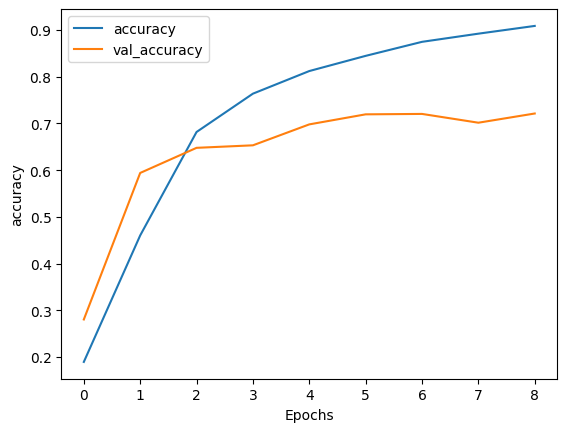

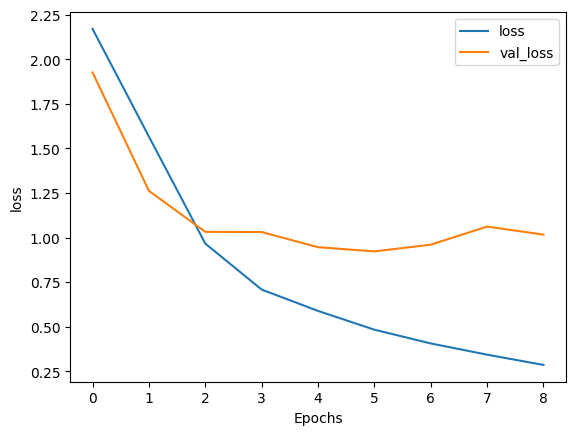

In [ ]:
def plot_graphs(history_I, metric):
    plt.plot(history_I.history[metric])
    plt.plot(history_I.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_I, "accuracy")
plot_graphs(history_I, "loss")

### Loading saved model

In [ ]:
model_cnn = tf.keras.models.load_model('./saved_models/cnn_model')

2023-03-01 11:32:31.837823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 11:32:31.838999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 11:32:31.839920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 11:32:31.840632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

### Model Evaluation and testing

In [ ]:
cnn_pred = model_cnn.predict(test_padded)
cnn_pred = np.argmax(cnn_pred,axis=1)

2023-03-01 11:32:38.773984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800


117/117 [==============================] - 4s 3ms/step


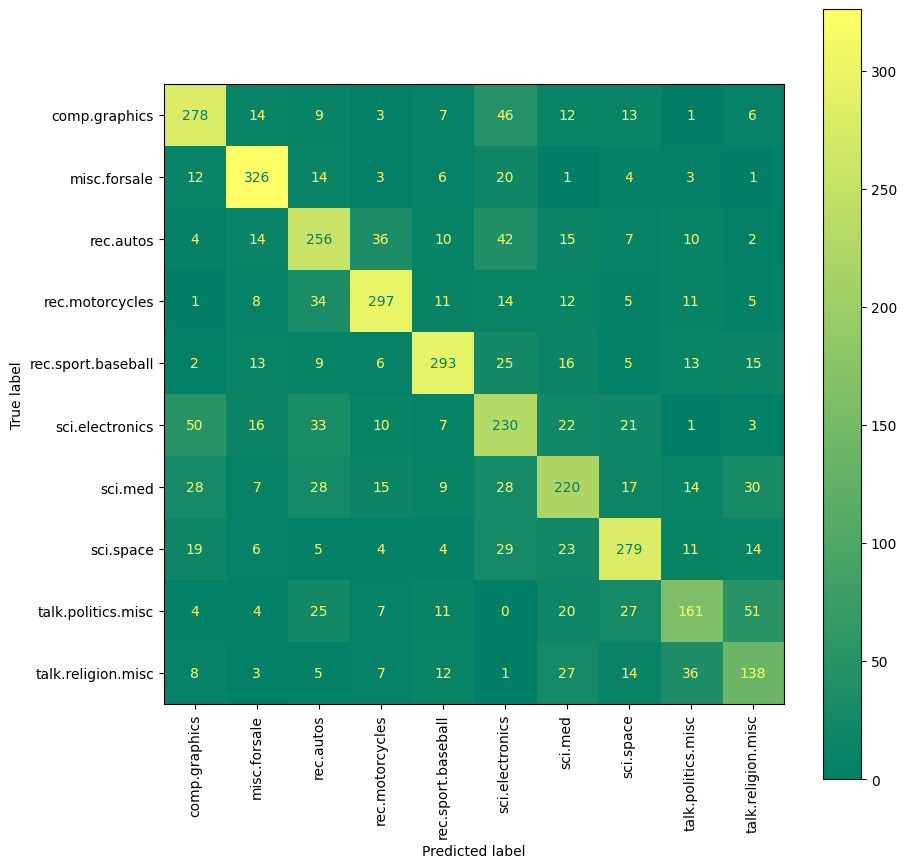

In [ ]:
cm = confusion_matrix(test_y, cnn_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels= train_data.target_names
)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

In [ ]:
pd.DataFrame(classification_report(test_y, cnn_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.684729,0.714653,0.699371,389.000000
1,0.793187,0.835897,0.813983,390.000000
2,0.612440,0.646465,0.628993,396.000000
3,0.765464,0.746231,0.755725,398.000000
4,0.791892,0.738035,0.764016,397.000000
5,0.528736,0.585242,0.555556,393.000000
6,0.597826,0.555556,0.575916,396.000000
7,0.711735,0.708122,0.709924,394.000000
8,0.616858,0.519355,0.563923,310.000000
9,0.520755,0.549801,0.534884,251.000000


## Deep learning II - Recurrent Neural Network
To compare, it was tested another model using LSTM, a widely known algorithm to text data

In [ ]:
def create_model_RNN(hp):
    """
    Creates a text classifier model

    Returns:
        model (tf.keras Model): the text classifier model
    """

    hp_activation = hp.Choice('Activation',values=['relu','tanh'])
    hp_layer_1    = hp.Int('units',min_value=16,max_value=128,step=16)
    hp_layer_LSTM = hp.Int('LSTM',min_value=10,max_value=100,step=10)
    hp_embedding  = hp.Int('embedding',min_value=16,max_value=64,step=8)
    
    tf.random.set_seed(42)
    
    model = Sequential()

    model.add(Embedding(1000,16, input_length = 150))
    model.add(Bidirectional(LSTM(hp_layer_LSTM)))
    model.add(Dense(units=hp_layer_1, activation=hp_activation))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
                           'accuracy']) 
    
    model.summary()


    return model

In [ ]:
tuner = kt.Hyperband(create_model_RNN,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='models',
                     project_name = 'rnn_model'
                     )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=0.001,patience=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 16)           16000     
                                                                 
 bidirectional (Bidirectiona  (None, 20)               2160      
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 18,666
Trainable params: 18,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tuner.search(train_padded, train_y, 
            epochs=50, validation_data=(val_padded, val_y),
            callbacks=[early_stop])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 01m 22s]
val_accuracy: 0.6639785170555115

Best val_accuracy So Far: 0.6684587597846985
Total elapsed time: 00h 40m 44s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.hypermodel.build(best_hps)

history_II = model.fit(train_padded, train_y, 
                    epochs=50, validation_data=(val_padded, val_y),
                    callbacks=[early_stop])

model.save('./saved_models/rnn_model')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 16)           16000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 84)               19824     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 96)                8160      
                                                                 
 dense_7 (Dense)             (None, 10)                970       
                                                                 
Total params: 44,954
Trainable params: 44,954
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
140/140 [==============================] - 14s 71ms/step - loss: 2.2054 - sparse_categorical_accuracy: 0.

INFO:tensorflow:Assets written to: ./saved_models/rnn_model/assets


INFO:tensorflow:Assets written to: ./saved_models/rnn_model/assets


In [ ]:
def plot_graphs(history_II, metric):
    plt.plot(history_II.history[metric])
    plt.plot(history_II.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history_II, "accuracy")
plot_graphs(history_II, "loss")

### Loading saved model

In [ ]:
model_rnn = tf.keras.models.load_model('./saved_models/rnn_model')

### Model Evaluation and testing

In [ ]:
rnn_pred = model_rnn.predict(test_padded)
rnn_pred = np.argmax(rnn_pred,axis=1)

 19/117 [===>..........................] - ETA: 0s

2023-03-01 14:24:39.713167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800


117/117 [==============================] - 2s 6ms/step


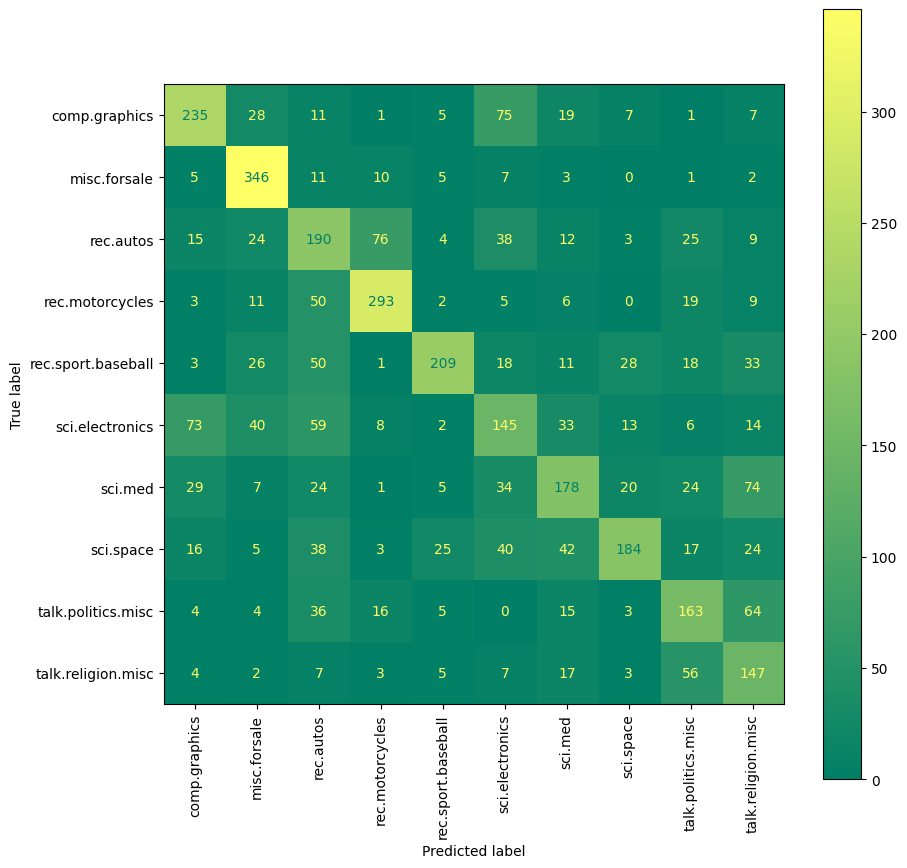

In [ ]:
cm = confusion_matrix(test_y, rnn_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels= train_data.target_names
)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

In [ ]:
pd.DataFrame(classification_report(test_y, rnn_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.607235,0.604113,0.605670,389.000000
1,0.701826,0.887179,0.783692,390.000000
2,0.399160,0.479798,0.435780,396.000000
3,0.711165,0.736181,0.723457,398.000000
4,0.782772,0.526448,0.629518,397.000000
5,0.392954,0.368957,0.380577,393.000000
6,0.529762,0.449495,0.486339,396.000000
7,0.704981,0.467005,0.561832,394.000000
8,0.493939,0.525806,0.509375,310.000000
9,0.383812,0.585657,0.463722,251.000000


## RoBERTa Model

As a test and for comparison with the other algorithms. The others were trained and hyperparameters tuned, but RoBERTa doesn't need to be fully trained, only the final layers, so it will be a good comparison to the performance of algorithms on this dataset

### Configuration and training

Default distribution strategy in Tensorflow. Works on CPU and single GPU.

In [11]:
strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [12]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256

BATCH_SIZE = 2 * strategy.num_replicas_in_sync
EPOCHS = 3

In [13]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [14]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': (input_ids),
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [18]:
train_x_RBRT = roberta_encode(train_x, tokenizer)
val_x_RBRT   = roberta_encode(val_x, tokenizer)
test_x_RBRT  = roberta_encode(test_x, tokenizer)

train_y_RBRT = np.asarray(train_y, dtype='int32')
test_y_RBRT  = np.asarray(test_y, dtype='int32')
val_y_RBRT   = np.asarray(val_y, dtype='int32')

train_input = [train_x_RBRT['input_word_ids'],train_x_RBRT['input_mask'],train_x_RBRT['input_type_ids']]
val_input   = [val_x_RBRT['input_word_ids'],val_x_RBRT['input_mask'],val_x_RBRT['input_type_ids']]
test_input  = [test_x_RBRT['input_word_ids'],test_x_RBRT['input_mask'],test_x_RBRT['input_type_ids']]

In [16]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype='int32')#, name='input_word_ids'
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype='int32')#, name='input_mask'
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype='int32')#, name='input_type_ids'

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
                     'accuracy'])

        return model

In [18]:
n_categories = len(categories)

with strategy.scope():
    model = build_model(n_categories)
    model.summary()

2023-03-07 15:04:15.873811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 15:04:15.875168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 15:04:15.876086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 15:04:15.876907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]',            

/home/battisaco/virtualenvs/NLP_20/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
with strategy.scope():
    print('Training...')
    history = model.fit(x=train_input,
                        y=train_y_RBRT,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(val_input, val_y))

print('saving model')   
model.save_weights(f'./saved_models/RoBERTa_model/RoBERTa_model.h5')

Training...
Epoch 1/3
2231/2231 [==============================] - 628s 277ms/step - loss: 0.5714 - sparse_categorical_accuracy: 0.8194 - accuracy: 0.8194 - val_loss: 0.2310 - val_sparse_categorical_accuracy: 0.9355 - val_accuracy: 0.9355
Epoch 2/3
2231/2231 [==============================] - 641s 287ms/step - loss: 0.1722 - sparse_categorical_accuracy: 0.9487 - accuracy: 0.9487 - val_loss: 0.2066 - val_sparse_categorical_accuracy: 0.9400 - val_accuracy: 0.9400
Epoch 3/3
2231/2231 [==============================] - 634s 284ms/step - loss: 0.0945 - sparse_categorical_accuracy: 0.9715 - accuracy: 0.9715 - val_loss: 0.4378 - val_sparse_categorical_accuracy: 0.8943 - val_accuracy: 0.8943
saving model


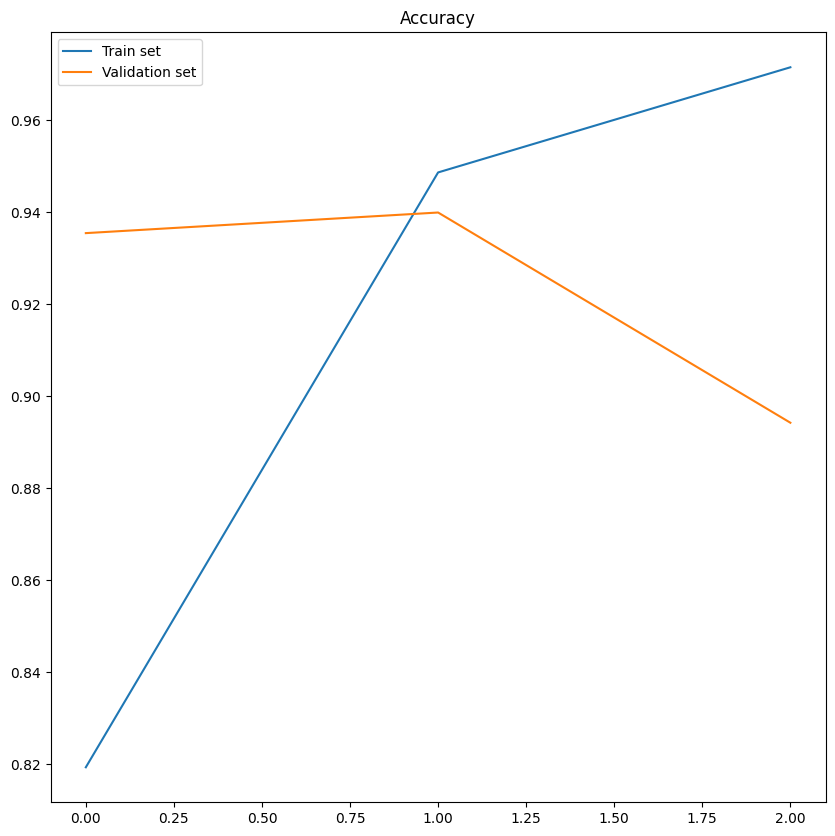

In [21]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

### Loading saved model

In [19]:
n_categories = len(categories)

with strategy.scope():
    model_RoBERTa = build_model(n_categories)
    model_RoBERTa.load_weights(f'./saved_models/RoBERTa_model/RoBERTa_model.h5')
    model_RoBERTa.summary()

2023-03-08 12:25:06.662079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 12:25:06.663502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 12:25:06.664586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 12:25:06.665973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]',            

### Model Evaluation and testing

In [20]:
RoBERTa_pred = model_RoBERTa.predict(test_input)
RoBERTa_pred = np.argmax(RoBERTa_pred,axis=1)

117/117 [==============================] - 106s 880ms/step


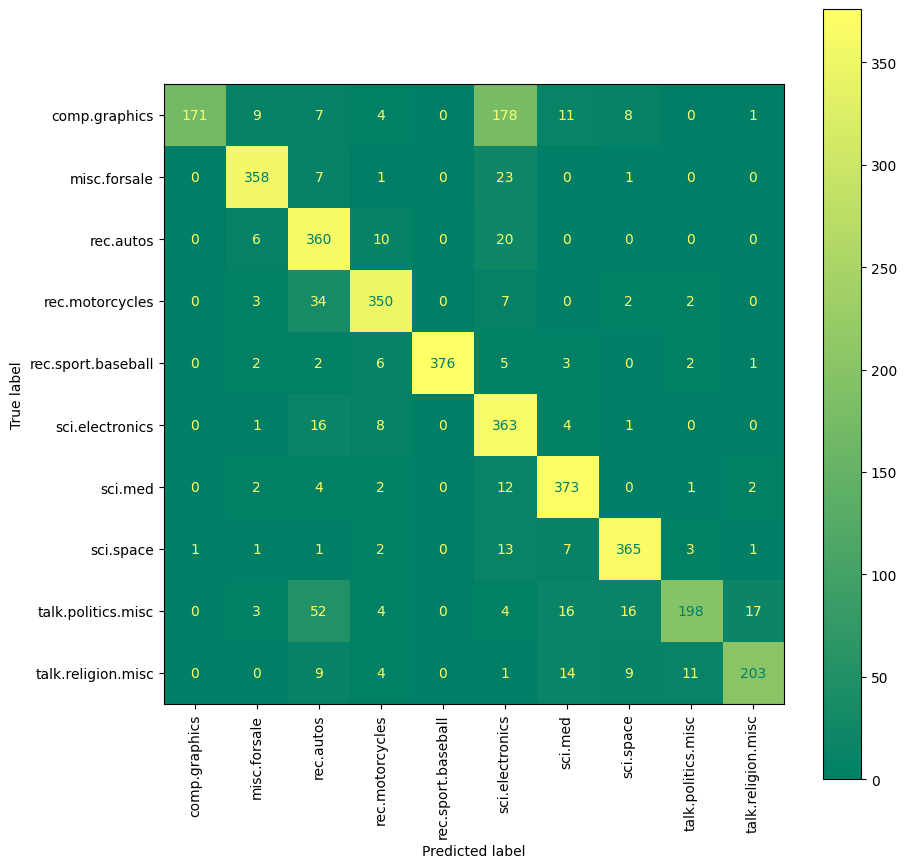

In [21]:
cm = confusion_matrix(test_y_RBRT, RoBERTa_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels= train_data.target_names
)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

In [43]:
pd.DataFrame(classification_report(test_y_RBRT, RoBERTa_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.994186,0.439589,0.609626,389.000000
1,0.929870,0.917949,0.923871,390.000000
2,0.731707,0.909091,0.810811,396.000000
3,0.895141,0.879397,0.887199,398.000000
4,1.000000,0.947103,0.972833,397.000000
5,0.579872,0.923664,0.712463,393.000000
6,0.871495,0.941919,0.905340,396.000000
7,0.907960,0.926396,0.917085,394.000000
8,0.912442,0.638710,0.751423,310.000000
9,0.902222,0.808765,0.852941,251.000000
